In [1]:
%cd ../../..

/home/eduardo/Desktop/Projects/Tech-Test-ML-Coin


In [54]:
import time

import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from torchvision.transforms import ToPILImage

from src.experiment.classical_cv.utils import SegmentationOutput
from src.experiment.utils import get_train_val_split, calculate_iou

In [3]:
(x_train, y_train), (x_val, y_val) = get_train_val_split(val_size=0)

In [45]:
y_train

['data/mask/0073.png',
 'data/mask/0018.png',
 'data/mask/0118.png',
 'data/mask/0078.png',
 'data/mask/0076.png',
 'data/mask/0031.png',
 'data/mask/0064.png',
 'data/mask/0141.png',
 'data/mask/0068.png',
 'data/mask/0082.png',
 'data/mask/0110.png',
 'data/mask/0012.png',
 'data/mask/0036.png',
 'data/mask/0009.png',
 'data/mask/0019.png',
 'data/mask/0056.png',
 'data/mask/0104.png',
 'data/mask/0069.png',
 'data/mask/0055.png',
 'data/mask/0132.png',
 'data/mask/0029.png',
 'data/mask/0127.png',
 'data/mask/0026.png',
 'data/mask/0128.png',
 'data/mask/0131.png',
 'data/mask/0145.png',
 'data/mask/0108.png',
 'data/mask/0143.png',
 'data/mask/0045.png',
 'data/mask/0030.png',
 'data/mask/0022.png',
 'data/mask/0015.png',
 'data/mask/0065.png',
 'data/mask/0011.png',
 'data/mask/0042.png',
 'data/mask/0146.png',
 'data/mask/0051.png',
 'data/mask/0027.png',
 'data/mask/0004.png',
 'data/mask/0032.png',
 'data/mask/0142.png',
 'data/mask/0085.png',
 'data/mask/0086.png',
 'data/mask

In [4]:
model_id = "CIDAS/clipseg-rd64-refined"
processor = CLIPSegProcessor.from_pretrained(model_id)
model = CLIPSegForImageSegmentation.from_pretrained(model_id)

In [5]:
prompt = "all circle shaped objects that resemble a coin"
images = [Image.open(f) for f in x_train[:10]]
inputs = processor(text=[prompt]*len(images), images=images, padding="max_length", return_tensors="pt")
  
start = time.time()
with torch.no_grad():
    outputs = model(**inputs)
    preds = outputs.logits

end = time.time()

In [103]:
masks = [(pred.sigmoid().numpy()*255).astype(np.uint8) for pred in preds]
masks = [cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)[1] for mask in masks]

In [104]:
ground_truth = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in y_train[:10]]

In [105]:
outputs = []
for mask, gt, image in zip(masks, ground_truth, images):
    image = np.array(image)
    original_height, original_width = gt.shape
    mask_resized = cv2.resize(mask.copy(), (original_width, original_height), interpolation=cv2.INTER_NEAREST)
    iou = calculate_iou(mask_resized, gt)
    outputs.append(SegmentationOutput(iou, image, mask_resized, gt, "", ""))

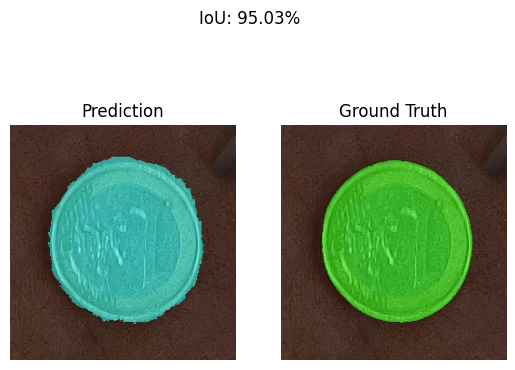

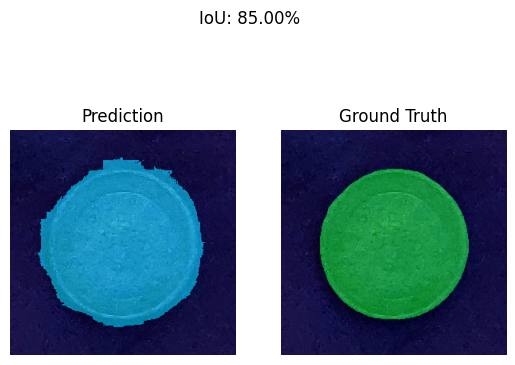

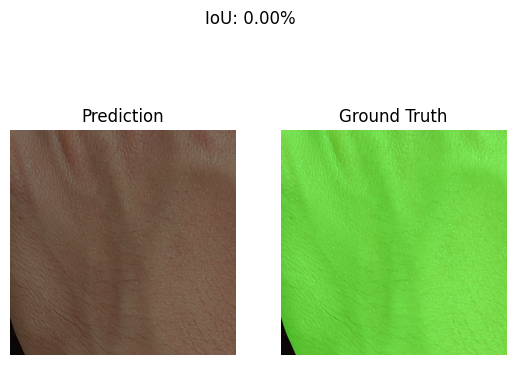

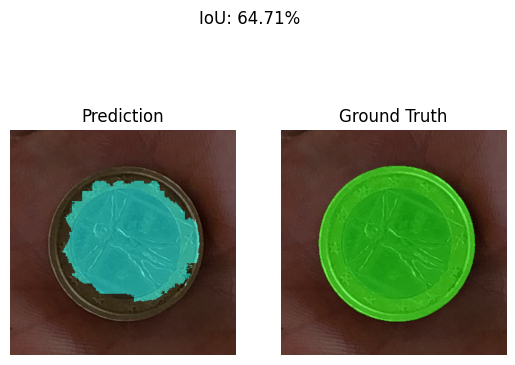

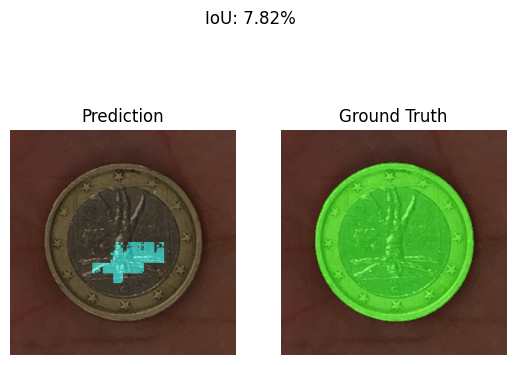

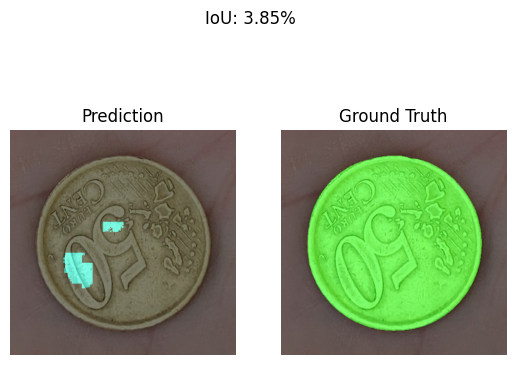

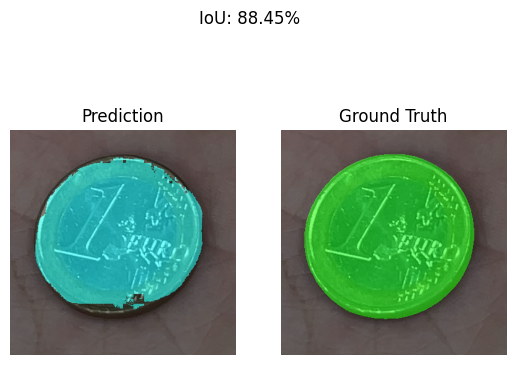

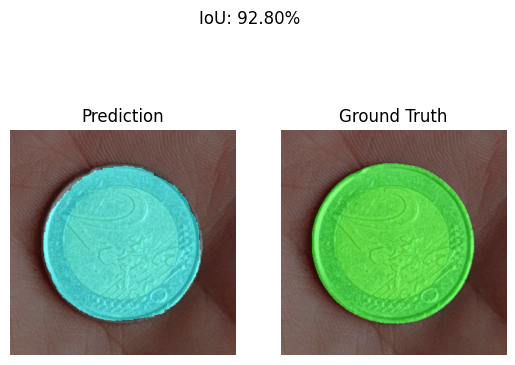

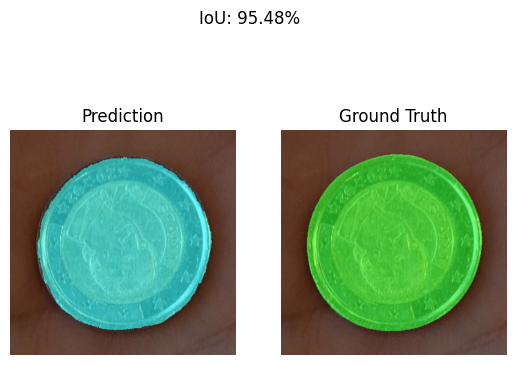

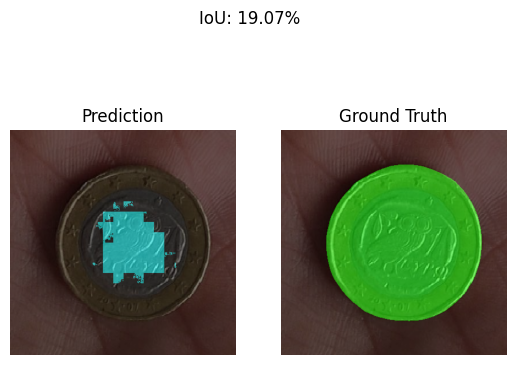

In [106]:
for out in outputs:
    out.plot_segmentation()